### A minimal example of feature visualization using bare PyTorch.

Using various forms of regularization to produce better visualizations will be left to another day.
See https://distill.pub/2017/feature-visualization/ for inspiration.

In [0]:
# Imports / Setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
from IPython import display
from torch import nn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math

In [0]:
# Functions for normalizing an image tensor.

def gauss_normalize(t):
    t = t.clone()
    for c in range(3):
        chan = t[c]
        t[c] += chan.mean()
        t[c] /= chan.std()
    return t

def stretch_normalize(t):
    t = t.clone()
    for c in range(3):
        chan = t[c]
        t[c] -= chan.min()
        t[c] /= chan.max() - chan.min()
    return t

In [236]:
# Use GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Get VGG16 pretrained on Imagenet.
model = torchvision.models.vgg16(pretrained=True)
model.to(device)
print(model)

# Set up hooks to get output of intermediate layer we want to visualize.
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6?u=ptrblck
act = None
def hook(model, input, output):
    global act
    act = output

# Max pool layers at 4, 9, 16, 23, 30
layer_ind = 30
hook = model.features[layer_ind].register_forward_hook(hook)

cuda:0
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17):

In [79]:
from scipy.ndimage.filters import gaussian_filter

def tensor_to_np(t):
  return t.detach().cpu().numpy().transpose([1, 2, 0])
  
def np_to_tensor(a):
  return torch.from_numpy(a).to(device).permute(2, 0, 1)

a = np.random.randint(0, 256, (56, 56, 3))
a.shape
t = np_to_tensor(a)
t.shape
a2 = tensor_to_np(t)
a2.shape
np.array_equal(a, a2)

True

In [0]:
# Make random input tensor.
# Run this cell each time you want to start the SGD loop
# from a random state.
# 224, 112, 56
inp = torch.randn((3, 112, 112), device=device)
inp = inp.unsqueeze(0)
inp.requires_grad = True

# Normalize input.
inp.data = gauss_normalize(inp.squeeze()).unsqueeze(0)

step:  0 activation:  0.0
step:  50 activation:  134.49913024902344
step:  100 activation:  404.0797119140625
step:  150 activation:  508.5676574707031
step:  200 activation:  626.42822265625
step:  250 activation:  1030.559814453125
step:  300 activation:  1747.78076171875
step:  350 activation:  3376.04345703125
step:  400 activation:  7041.5419921875
step:  450 activation:  14813.001953125
step:  500 activation:  28922.314453125
step:  550 activation:  49282.8125


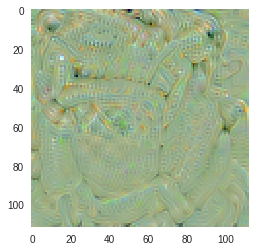

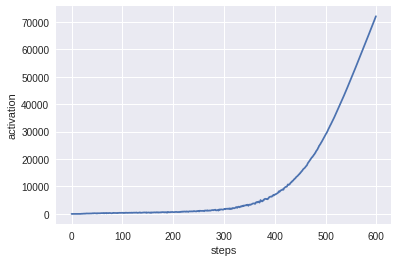

In [251]:
# Optimize input tensor to maximize sum of a channel in a layer.
# - It seems that use need to use more steps for higher layers.
# - Some random inits lead to zero activation and never improve.

channel_ind = 164
lr = 1.0
steps = 600
print_interval = 50
do_animate = False
do_blur = True
act_sums = []
  
def plot_input(inp):
    norm_inp = stretch_normalize(inp.squeeze())
    norm_inp_np = tensor_to_np(norm_inp)
    plt.imshow(norm_inp_np)
    plt.grid(False)
   
# SGD loop
for s in range(steps):
    # Compute sum of activations and backpropagate.
    out = model.features(inp)
    act_sum = act[0, channel_ind, :, :].sum()
    act_sum.backward()
    act_sums.append(act_sum.item())

    # Update input using gradient of input.
    with torch.no_grad():
        inp += inp.grad * lr
        inp.grad.zero_()
        model.zero_grad()
        
        # Try blurring
        if do_blur:
          sigma = ((1.0 - (s / steps)) * 0.5) + 0.2
          blurred = gaussian_filter(tensor_to_np(inp.squeeze()), sigma=sigma)
          inp.copy_(np_to_tensor(blurred).unsqueeze(0))
          # plot_input(inp)
          
        
    if s % print_interval == 0:
        print('step: ', s, 'activation: ', act_sum.item())
        
        if do_animate:
            plot_input(inp)
            display.clear_output(wait=True)
            display.display(plt.gcf())

# Plots            
plot_input(inp)
plt.show()

plt.plot(np.arange(0, steps), np.array(act_sums))
plt.xlabel('steps')
plt.ylabel('activation')
plt.show()